In [2]:
%run common.py

Planning start time: Aug 09, 07:30 (1470717049)


<a id='toc'></a>
## Содержание

1. [Вывозные локомотивы](#Вывозные-локомотивы)
2. [Сохранение времени явки бригады при перепланировании](#Сохранение-времени-явки-бригады-при-перепланировании)
3. [Планирование пересылок резервом](#Планирование-пересылок-резервом)
4. [Сдвиг явки УТХ-бригад](#Сдвиг-явки-УТХ-бригад)
5. [Главные проблемы с входными данными](#Главные-проблемы-с-входными-данными)
6. [Учет порядка времен явки бригад и порядка прибытия поездов на станцию](#Учет-порядка-времен-явки-бригад-и-порядка-прибытия-поездов-на-станцию)
7. [Равномерное распределение остатка поездов по часам](#Равномерное-распределение-остатка-поездов-по-часам)
8. [Исправления в обработке входных данных](#Исправления-в-обработке-входных-данных)
---

<a id='vyv'></a>

## Вывозные локомотивы

### Задания

#### Войтенко/Фрольцову:
~~1. Составить список локомотивов, которые работают на Восточном полигоне в вывозном движении. Для каждого локомотива указать номер, серию, ЕСР-код и название депо приписки.~~

От Фрольцова поступило предложение определять вывозной тип локомотива по атрибуту "вывозной", который (по его словам) есть в АСОУП.

#### Вздыхалкину/Науменко:
1. Разработать сущность онтологии, в которой хранить список вывозных локомотивов.

#### Башанову/Каштанову:
1. Разработать форму в АРМе Технолога, в которой показывать вывозные локомотивы.
2. Реализовать возможность редактирования списка вывозных локомотивов через эту форму (добавление / удаление).

#### Костенко:
1. Загрузить исходный справочник вывозных локомотивов в разработанную сущность.
2. Передавать вывозные локомотивы в планировщик с типом 2.

#### Смилге:
1. Реализовать алгоритм планирования вывозных локомотивов в планировщике.

### Алгоритм планирования вывозных локомотивов

1.	Локомотивы с типом «Вывозной» (это локомотивы со значением атрибута type = 2 в сообщении loco_attributes) должны работать преимущественно на коротких локомотивных слотах. Такие локомотивы чаще всего используются для развоза поездов внутри одного-двух УОЛБов.
2.	По этому критерию локомотиву дается добавка в функцию полезности, если это вывозной локомотив, а время хода по локомотивному слоту – небольшое.
3.	В качестве «серединного» значения выбрано время хода в 16 часов. Это связано с тем, что время хода по одному УОЛБу – примерно 6-8 часов. Соответственно, при таком выборе «длинными» будут считаться маршруты длиннее двух УОЛБов.
4. При расчете функции полезности при назначении локомотива на поезд для вывозных локомотивов прибавлять слагаемое $$f(t)=\frac{2}{1+\exp⁡{(k(t-t_0))}}-1$$, где $t$ – время хода по всему локомотивному слоту, выраженное в часах, $t_0=16$. Слагаемое входит в выражение для функции полезности только для локомотивов с типом «вывозной».
4. Из графика этой функции (см. ниже) видно, что при небольших временах хода по слоту (до 10 часов) вывозным локомотивам будет, по сути, добавляться +1 в функцию полезности, а при больших временах (больше 20 часов) – добавляться -1. Такая модель будет соответствовать реальным требованиям к планированию.
6.	На картинке приведено семейство графиков в зависимости от значения коэффициента под экспонентой (k). В формуле выше этот коэффициент равен 1. Его значение влияет на то, насколько график будет растянут возле среднего значения времени хода. Предлагается выбрать значение $k = 1.0$, а затем поменять в случае необходимости. Видно, что при больших k будет уменьшаться длина слотов, для которых будет добавка +1, с увеличением длины эта добавка будет убывать быстрее.

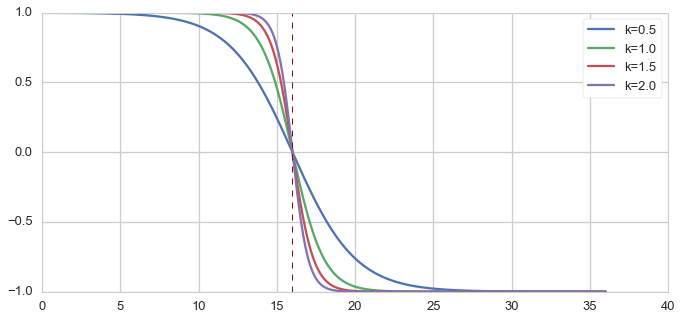

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

x0 = 16
x = np.linspace(0, 36, 1000)
plt.figure(figsize=(10, 5))
sns.set(style='whitegrid', context='talk')
sns.set_color_codes('dark')
for k in np.linspace(0.5, 2, 4):
    y = 2 / (1 + np.exp(k * (x - x0))) - 1
    plt.plot(x, y, label='k=%.1f' % k)
    
plt.plot([x0] * 20, np.linspace(-1, 1, 20), 'r--', lw=1.0)
plt.legend(frameon=True)
plt.show()

### Примеры планирования вывозных локомотивов

На плече Мариинск - Борзя работают вывозные локомотивы серии 2ЭС5К депо приписки Вихоревка. Эти локомотивы имеют номера от 80 до 87 включительно.

In [4]:
cols = ['loco', 'number', 'ser_name', 'depot_name', 'loc_name']
loco_info['ser_name'] = loco_info.series.map(loco_series.set_index('ser_id').ser_name)
loco_info.ser_name.fillna('-1', inplace=True)
loco_info['depot_name'] = loco_info.depot.map(st_names.name)
vyv = loco_info[(loco_info.ser_name.apply(lambda x: 'ЭС5К' in x)) & (loco_info.depot_name == 'ВИХОРЕВКА')
          & (loco_info.number >= 80) & (loco_info.number < 88)].sort_values(['depot_name', 'number'])
#nice_print(vyv, cols=cols, num=True)
vyv[cols]

,loco,number,ser_name,depot_name,loc_name
1668,200200031392,80,2ЭС5К,ВИХОРЕВКА,ТАЛЬЦЫ - ЧЕЛУТАЙ
1215,200200100898,81,2ЭС5К,ВИХОРЕВКА,ЛЕНА
1532,200200090764,82,2ЭС5К,ВИХОРЕВКА,КИТОЙ
124,200200090702,83,2ЭС5К,ВИХОРЕВКА,КАСЬЯНОВКА
1609,200200080455,84,2ЭС5К,ВИХОРЕВКА,КИТОЙ-КОМБИНАТСКАЯ
1328,200200058242,85,2ЭС5К,ВИХОРЕВКА,ИРКУТСК-СОРТИРОВОЧНЫЙ
1223,200200058339,86,2ЭС5К,ВИХОРЕВКА,ВОЕННЫЙ ГОРОДОК
1191,200200056605,87,2ЭС5К,ВИХОРЕВКА,КАРЫМСКАЯ


In [5]:
cols = ['loco', 'number', 'ser_name', 'regions', 'st_from_name', 'st_to_name', 'time_start', 'time_end', 'train']
loco_plan['ser_name'] = loco_plan.series.map(loco_series.set_index('ser_id').ser_name)
loco_plan['depot_name'] = loco_plan.depot.map(st_names.name)
a = loco_plan[loco_plan.loco.isin(vyv.loco)][cols]
start_st = a.drop_duplicates(subset=['loco', 'train'])
end_st = a.drop_duplicates(subset=['loco', 'train'], keep='last')
trips = start_st[['loco', 'regions', 'train', 'number', 'ser_name', 'st_from_name', 'time_start']].set_index(['loco', 'train'])\
    .join(end_st[['loco', 'train', 'st_to_name', 'time_end']].set_index(['loco', 'train']))\
    .reset_index()[cols].sort_values('number')
    
trips['tt'] = np.round(((trips.time_end - trips.time_start) / 3600), 2)
trips

,loco,number,ser_name,regions,st_from_name,st_to_name,time_start,time_end,train,tt
3,200200031392,80,2ЭС5К,['2002119299'],ТАЛЬЦЫ,ЧЕЛУТАЙ,1470653400,1470656671,200023229319,0.91
4,200200031392,80,2ЭС5К,['2002119299'],ЧЕЛУТАЙ,КАЯ,1470717049,1470776470,88880001104335,16.51
5,200200031392,80,2ЭС5К,['2002119299'],КАЯ,ИРКУТСК-СОРТИРОВОЧНЫЙ,1472640058,1472642505,88880016104333,0.68
6,200200031392,80,2ЭС5К,['2002119299'],ИРКУТСК-СОРТИРОВОЧНЫЙ,ИРКУТСК-СОРТИРОВОЧНЫЙ,1472642505,1472653305,-1,3.00
0,200200100898,81,2ЭС5К,['2002119301'],ЛЕНА,НОВЫЙ УОЯН,1470724200,1470790920,88880014364858,18.53
1,200200100898,81,2ЭС5К,['2002119301'],НОВЫЙ УОЯН,ТАЙШЕТ,1470811500,1470947541,200023534466,37.79
2,200200100898,81,2ЭС5К,['2002119301'],ТАЙШЕТ,КОРШУНИХА-АНГАРСКАЯ,1470981176,1471028372,999912387032000,13.11
18,200200090764,82,2ЭС5К,['2002119299'],ЗАОЗЕРНАЯ,БАЗАИХА,1470936990,1470947700,999928799012001,2.98
17,200200090764,82,2ЭС5К,['2002119299'],ЗИМА,ЗАОЗЕРНАЯ,1470865500,1470926400,88880017964573,16.92
15,200200090764,82,2ЭС5К,['2002119299'],ИРКУТСК-СОРТИРОВОЧНЫЙ,ЗИМА,1470827400,1470843944,999912394012013,4.60


<a id='pr_save'></a>

[В начало](#Содержание)
## Сохранение времени явки бригады при перепланировании

Для бригад, которые были запланированы на предыдущем запуске, будет передаваться ранее запланированное время явки $t_{prev}$. Если бригада была запланирована на явку ранее в достаточно близком горизонте от времени запуска планировщика, то ей нельзя сильно менять время явки, поскольку она, скорее всего, уже находится в пути из дома в депо, и мы не можем просто так заставить ее сидеть в ожидании поезда еще несколько часов или же заставлять отправляться раньше уже запланированного времени.

Предложения по доработке такие:

1. Назовем "пред-бригадой" бригаду, для которой передано $t_{prev}$.
2. Если для пред-бригады передано исходное состояние $state \neq 3$, то планировать ее по обычному алгоритму (т.к. она уже вышла на работу, для нее уже есть фактическая явка).
3. Если для пред-бригады передано исходное состояние $state = 3$, то устанавливать для нее $state = 2$ с временем явки = $t_{prev}$.
4. Для бригад со $state = 2$ ввести дополнительное слагаемое в функции полезности, которое бы сильно штрафовало за подвязку с локомотивам с поздним временем отправления (если бригада будет ждать локомотив) и сильно бы повышало полезность за подвязку к уже готовым к отправлению локомотивам. В этом случае бригада со $state = 2$ будет скорее подвязываться под готовые локомотивы и не будет сильно задерживаться на станции.
5. Предлагается в качестве этого слагаемого брать значение $$u(t) = \frac{2}{1 + \exp{k(t-t_0-\Delta)}} - 1$$
6. Параметры этой функции: 
  1. $t_0$ - время явки бригады (из сообщения `+fact_team_ready` или $t_{prev}$ из сообщения о пред-бригаде)
  2. $\Delta$ - допустимое отклонение от времени явки бригады. Оно зависит от "горизонта явки бригады":
    1. Если $t_0$ лежит на горизонте 3 часов от начала планирования, то $\Delta = 0.25$;
    2. Если $t_0$ лежит на горизонте 6 часов от начала планирования, то $\Delta = 0.5$;
    3. Если $t_0$ лежит на горизонте 12 часов от начала планирования, то $\Delta = 1.0$;    
  2. $k \approx \frac{10}{\Delta}$
  
7. TODO: Додумать такой момент: явку не двигать, но время отправления поезда сдвигать можно. Узнать у технологов, на сколько время отправления может быть позже времени явки.

k_opt = 30.4036, k_round = 20.00


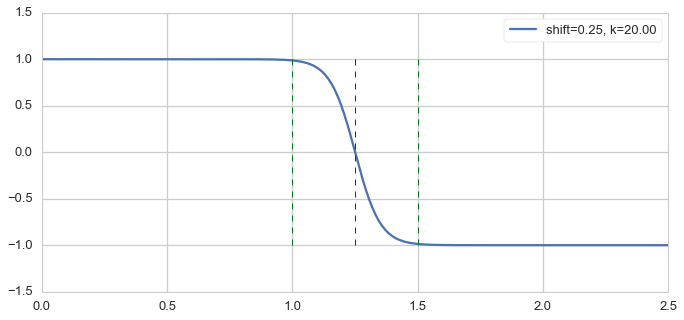

In [6]:
shift = 0.25
precision = 200
epsilon = 0.001
t_pres = 1
k_opt = np.log(2 / epsilon) / shift
k_round = 5 / shift
print('k_opt = %.4f, k_round = %.2f' % (k_opt, k_round))

x = np.linspace(-0, 2.5, precision)
y = 2/(1 + np.exp(k_round * ((x - t_pres) - shift))) - 1
yc = np.linspace(-1, 1, precision)
yc1 = [1.0] * precision
plt.figure(figsize=(10, 5))
sns.set(style='whitegrid', context='talk')
sns.set_color_codes('dark')
plt.plot(x, y, label='shift=%.2f, k=%.2f' % (shift, k_round))
plt.plot([t_pres + shift] * precision, yc, 'r--', lw=1.0)
plt.plot([t_pres] * precision, yc, 'g--', lw=1.0)
plt.plot([t_pres + 2 * shift] * precision, yc, 'g--', lw=1.0)
#plt.plot(x, [1.0] * precision, 'g--', lw=1.0)
axes = plt.gca()
axes.set_ylim([-1.5, 1.5])
plt.legend(frameon=True)
plt.show()

<a id='res'></a>

[В начало](#Содержание)
## Планирование пересылок резервом

Есть случаи очень дальней пересылки локомотивов резервом. Такая пересылка нерациональна: за те много часов, которые локомотив едет, может случиться что угодно - и локомотив уже окажется ненужным. Поэтому предлагается ограничить "окно" пересылки локомотивов резервом: искать локомотивы только на станциях, до которых ехать сравнительно недолго. В качестве такого окна предлагается взять 15 часов, затем корректировать при необходимости.

### Составляем таблицу с поездками локомотивов резервом

In [7]:
cols = ['loco', 'number', 'ser_name', 'st_from_name', 'st_to_name', 'time_start', 'time_end', 'train', 'n_state']
loco_plan['n_state'] = loco_plan.state.shift(-1)
loco_plan['loco_end'] = loco_plan.loco != loco_plan.loco.shift(-1)
loco_plan.loc[loco_plan.loco_end == True, 'n_state'] = -1
loco_plan_res = loco_plan[loco_plan.state == 0]
start_st = loco_plan_res.drop_duplicates(subset=['loco', 'train'])
end_st = loco_plan_res.drop_duplicates(subset=['loco', 'train'], keep='last')
trips = start_st[['loco', 'regions', 'train', 'number', 'ser_name', 'st_from_name', 'time_start']].set_index(['loco', 'train'])\
    .join(end_st[['loco', 'train', 'st_to_name', 'time_end', 'n_state']].set_index(['loco', 'train']))\
    .reset_index()[cols].sort_values('number')
    
trips['tt'] = np.round(((trips.time_end - trips.time_start) / 3600), 2)

# Загрузка "чистых" времен хода (не запланированных, без учета стоянок на смену бригад)
# Отсечка при планировании будет производиться именно по ним
default_tt = pd.read_csv(FOLDER + '/mandatory/travel_times_all_pairs.csv', sep=';')
def_tt = default_tt.set_index(['st_from_name', 'st_to_name']).to_dict()['tt']
trips['def_tt'] = trips.apply(lambda row: np.round(def_tt[(row.st_from_name, row.st_to_name)] / 3600, 2), axis=1)

cols = ['loco', 'number', 'ser_name', 'st_from_name', 'st_to_name', 'train', 'def_tt', 'tt']
nice_print(trips.sort_values('def_tt', ascending=False).head(), cols=cols)

KeyError: (('БИРОБИДЖАН I', 'БЕЛОГОРСК II'), 'occurred at index 1151')

### Статистика по временам пересылок

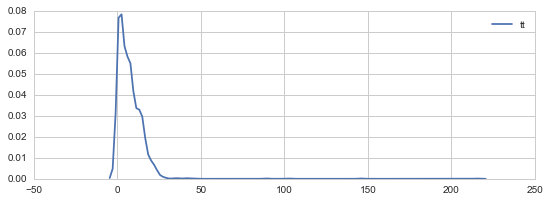

In [8]:
sns.set(style='whitegrid', context='notebook')
plt.figure(figsize=(8, 3))
sns.kdeplot(trips.tt)

### Поиск оптимальной границы

In [9]:
# От Войтенко: список примерных предельных маршрутов для локомотивов резервом

res_lims = [('НАХОДКА-ВОСТОЧНАЯ', 'ХАБАРОВСК II'), ('ХАБАРОВСК II', 'БЕЛОГОРСК II'),
('БЕЛОГОРСК II', 'СКОВОРОДИНО'), ('СКОВОРОДИНО', 'КАРЫМСКАЯ'), ('КАРЫМСКАЯ', 'УЛАН-УДЭ'), 
('УЛАН-УДЭ', 'ИРКУТСК-СОРТИРОВОЧНЫЙ'), ('ИРКУТСК-СОРТИРОВОЧНЫЙ', 'ТАЙШЕТ'), 
('ТАЙШЕТ', 'КРАСНОЯРСК-ВОСТОЧНЫЙ'), ('КРАСНОЯРСК-ВОСТОЧНЫЙ', 'МАРИИНСК')]

In [10]:
d = {}
for x in res_lims:
    d[x] = np.round(def_tt[x] / 3600, 2)    
lens = pd.DataFrame(d, index=np.arange(len(d.keys()))).transpose()[0]
print(lens.sort_values())

ТАЙШЕТ                 КРАСНОЯРСК-ВОСТОЧНЫЙ      6.93
КРАСНОЯРСК-ВОСТОЧНЫЙ   МАРИИНСК                  7.45
УЛАН-УДЭ               ИРКУТСК-СОРТИРОВОЧНЫЙ     7.83
БЕЛОГОРСК II           СКОВОРОДИНО              10.10
ИРКУТСК-СОРТИРОВОЧНЫЙ  ТАЙШЕТ                   11.46
ХАБАРОВСК II           БЕЛОГОРСК II             11.59
КАРЫМСКАЯ              УЛАН-УДЭ                 12.38
НАХОДКА-ВОСТОЧНАЯ      ХАБАРОВСК II             14.55
СКОВОРОДИНО            КАРЫМСКАЯ                19.55
Name: 0, dtype: float64


### Подсчет локомотивов, время пересылки резервом которых лежит за границей

In [11]:
lim_time = 15
print('Number of overtimed reserve trips: %d' % trips[trips.tt > lim_time].loco.count())
print('Rate of overtimed reserve trips: %.4f' % (trips[trips.tt > lim_time].loco.count() / trips.loco.count()))

Number of overtimed reserve trips: 217
Rate of overtimed reserve trips: 0.1110


### Выводы

1. В качестве верхней границы для времени пересылки локомотива резервом можно взять 15 часов. Из основных маршрутов локомотивов резервом такая отсечка сохранит все маршруты, кроме Сковородино - Карымская. Но по словам Войтенко, там возможна пересылка до Могочи. Впрочем, можно сделать исключение для локомотивов со станцией назначения Карымская в нечетном направлении - разрешить их пересылать при времени хода до 20 часов.
2. Всего в планах 20% от локомотивов, пересылающихся резервом, пересылаются на дальние расстояния (больше предельных 15 часов).
3. Пересылку на дальние расстояния резервом надо запретить и для пересылки на ТО. Впрочем, для любого положения локомотива наверняка найдется пункт ТО в радиусе этих 15 часов. Так что пока специальной проверки на это делать не надо. Имеющиеся случаи пересылки локомотивов на ТО с временем хода больше 15 часов - очень похожи на баги.

<a id='uth'></a>

[В начало](#Содержание)
## Сдвиг явки УТХ бригад

### Требования

УТХ планирует списочный состав бригад, которые выйдут на работу в депо в следующие сутки. Этот список был составлен по алгоритмам и данным, которые не используются в планировщике ОУЭР, поэтому эти бригады просто надо планировать раньше, чем другие бригады данного депо приписки.

### Входные данные

Для каждой бригады в планировщик ОУЭР передается три времени:
- время последней операции (oper_time);
- время последней явки в депо приписки (ready_time1);
- время последней явки в пункте оборота (ready_time2).

Также передается состояние бригады. Важным является состояние 3, оно соответствует тому, что бригада находится на домашнем отдыхе. Далее будем говорить **только про бригады в состоянии 3**.

Для УТХ-бригад в онтологию из УТХ передается планируемое время явки бригады. В планировщик ОУЭР оно передается как в атрибуте `ready_time1`, так и в атрибуте `oper_time`. Для не-УТХ-бригад в планировщик в атрибутах `oper_time` и `ready_time1` передается рассчитаное самое раннее допустимое время явки: это время ухода на отдых + 16 часов (для ухода на домашний отдых) или + 42 часа (для ухода на выходной день).

### Проблема

Может так получиться, что для не-УТХ-бригады рассчитанное время явки будет **меньше**, чем время явки какой-либо УТХ-бригады из данного депо. Такое может случиться, если не-УТХ-бригада ушла на отдых достаточно давно, но почему-то алгоритм УТХ не выбрал ее 
в списке бригад на следующие сутки (например, если всего было запрошено немного бригад или просто хватило более ранних бригад). В этом случае планировщик ОУЭР запланирует не-УТХ-бригаду раньше, чем какую-то УТХ-бригаду. А это неправильно.

Раньше (до 25.07.2016) такой проблемы не возникало (или она была не так заметна), поскольку сменно-суточное планирование ОУЭР запрашивало довольно много бригад. И в данном депо приписки просто не оставалось бригад, которые не попали в список бригад УТХ.

### Пути решения

В целом, не-УТХ-бригады надо каким-то образом задвигать на более позднее время. Например, можно в качестве планируемого времени явки не-УТХ-бригады брать не $t+16$ часов, а какое-то большее время, желательно за пределами текущих (следующих?) суток.

Предлагается вот какой вариант для определения времени явки для не-УТХ-бригады:

1. Берем самое позднее время явки среди всех УТХ-бригад данного депо приписки, которые были переданы в планировщик. Обозначим это время как $t_T$.
  1. Если в планировщик не было передано ни одной УТХ-бригады данного депо приписки, то для таких бригад ничего дополнительно не делаем, оставляем время явки неизменным.
2. Для каждой не-УТХ-бригады данного депо приписки считать разность $\Delta t = t_T - t_0$, где $t_0=\{t+16, t+42\}$ - планируемое (и передаваемое в планировщик) время явки этой бригады (увеличенное на 16 (42) часов время начала отдыха).
3. В качестве времени явки бригады брать значение $$t_N=t_T + 10 \cdot\exp{\left(-\frac{\Delta t}{20}\right)}$$
  * (в этой формуле все времена выражены в часах; если все времена будут выражены в секундах, то надо коэффициент перед экспонентой умножить на 3600, а выражение под экспонентой разделить на 3600).
4. Таким образом мы гарантируем, что время явки не-УТХ-бригад будет больше времени явок всех УТХ-бригад. Если у не-УТХ-бригады время готовности достаточно раннее, то $t_T-t_0$ велико и новое время явки будет близко к $t_T$. Если у не-УТХ-бригады время готовности достаточно позднее (возможно, больше $t_T$), то новое время явки будет далеко в будущем от $t_T$. Значит, бригады, которые раньше готовы к отправлению, будут и планироваться раньше.
5. Коэффициенты в формуле (10 и 20 в примере выше) можно подобрать экспериментально. Графики распределения времен для коэффициентов 10 и 20 показаны ниже. Так, для этих значений мы получим, что для не-УТХ-бригады, у которой время явки на 12 часов меньше предельного $t_T$ (например, при явке последней УТХ-бригады в 17:00 и рассчитанной явке не-УТХ-бригады в 05:00) новое время явки не-УТХ-бригады будет $t_N \approx t_T + 5 = 22$.

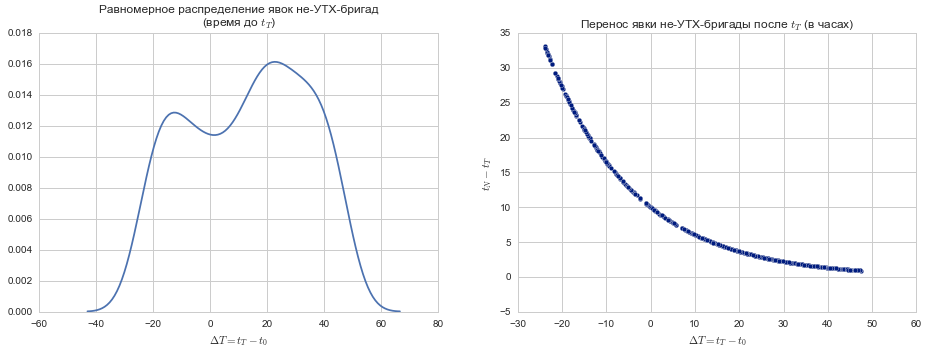

In [12]:
x = (np.random.randint(3 * 86400, size=500) / 3600) - 24
f = 10 * np.exp(-x/20)
plt.subplots(1, 2, figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.kdeplot(x)
plt.title('Равномерное распределение явок не-УТХ-бригад\n(время до $t_T$)')
plt.xlabel('$\Delta T = t_T - t_0$')
plt.subplot(1, 2, 2)
plt.title('Перенос явки не-УТХ-бригады после $t_T$ (в часах)')
plt.scatter(x, f)
plt.xlabel('$\Delta T = t_T - t_0$')
plt.ylabel('$t_N-t_T$')
plt.show()

Главный вопрос: где все эти операции производить - в онтологии при подготовке данных или в планировщике? Видимо, логичнее это делать в планировщике, поскольку эти расчеты уже не относятся напрямую к входным данным. Это скорее уже какое-то планирование, перенос каких-то бригад на более позднее время. 

Чтобы это реализовать в планировщике, к текущей реализации достаточно сделать такую доработку: для каждой бригады в сообщении `team_attributes` передавать атрибут `uth()`. Возможные значения признака: 0 - для не-УТХ-бригад, 1 - для УТХ-бригад. Получив этот признак для каждой бригады, планировщик сможет реализовать весь описанный выше алгоритм.

### FAQ

* **Что делать, если бригада была передана в планировщик ОУЭР как УТХ-бригада и была запланирована с каким-то временем явки, а на следующем запуске планировщика она уже передана как не-УТХ? Как в этом случае должен отработать алгоритм, который старается сохранить времена явок бригад между запусками?**

В принципе, таких случаев быть не должно. Если на одном запуске бригада является УТХ-бригадой, на втором нет, то значит, что между этими запусками планировщика ОУЭР был запуск планировщика УТХ. А значит, было и сменно-суточное планирование. После сменно-суточного планирования явки бригад не должны сохраняться.

Если все-таки такое случилось, то считаем, что УТХ-бригады более приоритетные, явки не-УТХ-бригад сдвигаем в будущее, даже если по ним были предыдущие явки.

* **Что делать на запуске планировщика в 16:30?**

На этом запуске мы должны допланировать старые УТХ-бригады (от предыдущих суток) на хвост 16:30 - 18:00, а затем запланировать новые. Значит, признак `uth` надо проставлять как для УТХ-бригад от прошлых суток, так и для свежих, которые были загружены перед запуском в 16:30.

* **А может УТХ-бригада от текущих суток успеть до запуска в 16:30 съездить на работу и уйти на домашний отдых?**

Может. Допустим, она отправлена из Иркутска в Зиму в 18:00. Время хода - около 5 часов. С учетом времени на приемку-сдачу можно сказать, что она уйдет на отдых в Зиму около 01:30. Ее минимальный отдых - около 4 часов, в 05:30 она выйдет на работу, может сразу принять локомотив и вернуться назад. Уход на домашний отдых может случиться примерно в 13:00. Это, конечно, достаточно экстремальный случай (должны сойтись звезды, что бригада была рано отправлена, отдыхала минимальное время и т.п.), но он возможен.

* **И что будет?**

Тогда будут проблемы. Потому что у этой бригады будет проставлен признак УТХ (от предыдущих суток). Время явки у нее будет либо полученное в предыдущих сутках от УТХ, либо время ухода на отдых + 16 часов (**уточнить у Варанкина**). В любом случае, она вполне сможет быть запланирована в следующих сутках, хотя в списке УТХ-бригад на следующие сутки ее, скорее всего, не будет.

Что делать с этим - пока непонятно. Наверное, в отсевах надо анализировать историю операций с бригадой: если бригада была в списке УТХ от текущих суток, ее нет в списке на следующие сутки и по ней были какие-то операции (кроме ухода на отдых) в текущие сутки, то передавать для нее признак `uth(0)`.

* **Что делать, если по не-УТХ-бригаде есть данные о предыдущей запланированной явке?**

Сдвиг явки не-УТХ бригады может конфликтовать с предыдущей запланированной явкой (см. [Сохранение явки бригады при перепланировании](#Сохранение-времени-явки-бригады-при-перепланировании)). Например, расчет планировщика случился в 13:30, явка бригады А была запланирована в 17:00, для бригад вообще не было признаков `uth`. Далее в 16:00 происходит расчет УТХ-планировщика - и оказывается, что бригады А нет среди УТХ-бригад депо приписки бригады А. Тогда мы, с одной стороны, должны стараться сохранить предыдущее время явки, но с другой - должны соблюсти приоритет УТХ-бригад и сдвинуть время явки не-УТХ-бригад. В этом случае признак `uth` приоритетнее: про предыдущее время явки таких бригад мы забываем, сдвигаем время явки по алгоритму, описанному в этом разделе.

[В начало](#toc)
## Главные проблемы с входными данными

### Не передаются три станции [JIRA VP-6730](http://jira.programpark.ru/browse/VP-6730)

В планировщик не поступают сообщения `+station` о станциях Биробиджан I, Биробиджан II и Камышовая. Поскольку в этом сообщении указывается id тягового плеча, которому принадлежит станция, то это приводит к тому, что в соответствующих тяговых плечах получаются дырки. Поэтому локомотивы и бригады не планируются на участках возле этих станций - все маршруты обрываются на подступах к этим станциям. Следствия могут быть разнообразными: например, увеличится количество пересылок локомотивов резервом, вырастет количество случаев проезда бригадами мимо станций смены и т.п.

### Сдвоенные поезда [JIRA VP-6015](http://jira.programpark.ru/browse/VP-6015)

Плохое качество данных:
* По многим поездам, которые указаны в атрибутах `joint` у составляющих поездов, не передаются сообщения `train_info` и сообщение об операции.
* Много случаев, когда определенный `id` сдвоенного поезда указан только для одного составляющего поезда (второй либо не передан, либо идет с `joint(-1)`).

### Неправильные местоположения поездов, локомотивов или бригад

Есть случаи (около 2% поездов и почти все бригады в `state(0)`), когда станция отправления бригады совпадает со станцией направления. Примеры - в отчете `input_report`.

Около 4% случаев, когда участка местоположения нет в маршруте поезда. Видимо, это связано с тем, что кратчайший маршрут строится от станции отправления без учета станции направления. Предлагаемое решение: строить маршрут от станции направления, а потом вручную прибавлять к нему в начало станцию отправления. Возможные подводные камни: оптимальный маршрут от станции направления может пролегать в обратном направлении - к станции отправления.

Около 20% от поездов, находящихся в пути, имеют очень старое время операции (есть случаи, когда время операции на 20 часов меньше времени начала планирования). Надо разобрать эти случаи, выяснить причины. По результатам анализа принять решения о доработках. Примеры - в отчете `input_report`.

Около 8% локомотивов имеют несовпадающий по местоположению или времени факт о связанной бригаде. Примеры - в отчете `input_report`.

### Станция Зыково не принадлежит ни одному участку обкатки бригад [JIRA VP-5633](http://jira.programpark.ru/browse/VP-5633)

Это приводит к тому, что реальные бригады не могут быть назначены на участок Красноярск-Восточный - Иланская.

### Вывозные локомотивы [JIRA VP-6955](http://jira.programpark.ru/browse/VP-6955)

Определять в онтологии, что локомотив является вывозным. Передавать соответствующий признак в планировщик. Планировать вывозные локомотивы на небольшие маршруты (см. требования к планировщику и список работ [здесь](#Вывозные-локомотивы)).

### Id типов ремонтов отличается в НСИ и у локомотивов [JIRA VP-6655](http://jira.programpark.ru/browse/VP-6655)

В сообщениях `+service_station` указаны одни id типов ремонтов, а в сообщениях `+fact_loco_next_service` - совершенно другие. Это приводит к тому, что планировщик не может выбрать станцию для проведения ТО у локомотивов.

_Не обязательно исправлять в онтологии, пока вполне достаточно будет костыля в планировщике, который будет игнорировать тип ремонта при поиске станции проведения ТО._

---

[В начало](#toc)
## Учет порядка времен явки бригад и порядка прибытия поездов на станцию

В этом разделе идет речь о расчете критерия "Очередность отправления бригад" в вычислении функции полезности для пары <локомотив, бригада>. Вместо слова "локомотив" здесь будет часто употребляться слово "поезд", поскольку для расчета по этому критерию поезд и локомотив, в принципе, являются одним и тем же. От них нам нужно будет только время готовности к отправлению.

### Текущая реализация

1. Пусть $T_T$ – время готовности бригады, $T_i$ – время готовности к отправлению $i$-го поезда на данной итерации планирования. Пусть $T_0$ – время отправления самого раннего поезда, но не раньше времени готовности бригады:$$T_0=\min_{T_i \geq T_T} T_i$$.
2. Если $T_T>T_i$ (бригада доступна позже времени отправления бригадного слота), то значение по этому критерию = 0.
3. В противном случае в качестве значения критерия брать $$U = \frac{T_0-T_T}{\exp⁡{\left(k\cdot (T_i-T_0)\right)}}$$ Тогда для самого раннего подходящего бригадного слота это значение будет равно $U_{max}=T_0-T_T$, и оно будет тем больше, чем раньше бригада готова на станции. Для следующих бригадных слотов это значение будет убывать по экспоненте. Коэффициент $k$ можно подобрать экспериментально (в качестве начального значения можно взять $k=1/3600$).
4. Для очень рано готовых бригад требуется ограничить рост значения по этому критерию, чтобы этот критерий не «забивал» все остальные в функции полезности. Для бригад, у которых $T_T<T_{cr}$, в качестве числителя в формуле для $U$ требуется брать не $T_0-T_T$, а $T_0-\frac{9∙T_{cr}+T_T}{10}$, где $T_{cr}=T_0-2\cdot 3600$ – критическое время «давности» бригад.


### Проблемы текущей реализации

1. Если время готовности поезда меньше, чем время готовности бригады, то эта пара будет получать полезность = 0. Это приведет к тому, что поезда, готовые к отправлению достаточно рано, могут планироваться довольно поздно (как повезет). Особенно это заметно в случаях, когда количество поездов меньше количества бригад (см. пример ниже).

2. Резкий скачок полезности, который происходит для поезда с временем $T_0$, может привести к тому, что более поздняя бригада может быть назначена на более ранний поезд.

3. Никак не учитывается тот факт, что для бригады, не находящихся на домашнем отдыхе, надо скорее подвязывать поезда, для них долгое ожидание неприемлемо.

In [99]:
team_num, slot_num = 10, 10

In [100]:
from random import randrange
import datetime as dt
sd = int(dt.datetime(2016, 8, 4).timestamp())
times = []
for i in range(team_num):
    times.append([randrange(2), dt.datetime.fromtimestamp(sd + 60 * int(randrange(6*3600) / 60))])
    
df = pd.DataFrame(times, columns = ['tt', 'time'])
names = ['Alice', 'Bob', 'Clark', 'David', 'Ed', 'Frank', 'George', 'Helen', 'Ivan', 'John', 'Kelly', 'Lance', 'Mario',
        'Nolan', 'Oleg', 'Paul', 'Quentin', 'Ricky', 'Steve', 'Thomas', 'Ulaf', 'Valera', 'Wayne', 'Xi', 'Yang', 'Zed']
df['name'] = names[:team_num]
df['ts'] = df.time.apply(lambda x: int(x.timestamp()))

In [101]:
times = []
for i in range(slot_num):        
    times.append([randrange(2), dt.datetime.fromtimestamp(sd + 4 * 3600 + 60 * int(randrange(7200) / 60))])
    
df_slot = pd.DataFrame(times, columns = ['tt', 'time'])
df_slot = df_slot.sort_values('time')
train_names = ['train' + str(x) for x in np.arange(slot_num)]
df_slot['name'] = train_names
df_slot['ts'] = df_slot.time.apply(lambda x: int(x.timestamp()))

In [102]:
def prev_util(x):
    t_t = x.ts
    u = []
    t_0 = df_slot[df_slot.ts >= t_t].ts.min()
    for t_i in train_times:
        if t_t > t_i:
            util = 0
        else:
            add = 0 if x.tt == 1 else 1 - (t_i - t_t) / 15000
            util = np.round(((t_0 - t_t) / np.exp((t_i - t_0) / 3600)) / 1000 + 1.0 * add, 3)
        u.append(util)
    return pd.Series(u)   

df.drop([x for x in df.columns if 'train' in x], axis=1, inplace=True)
train_list = sorted(df_slot.name.unique())
train_times = list(df_slot.ts.values)
df[train_list] = df.apply(lambda x: prev_util(x), axis=1)

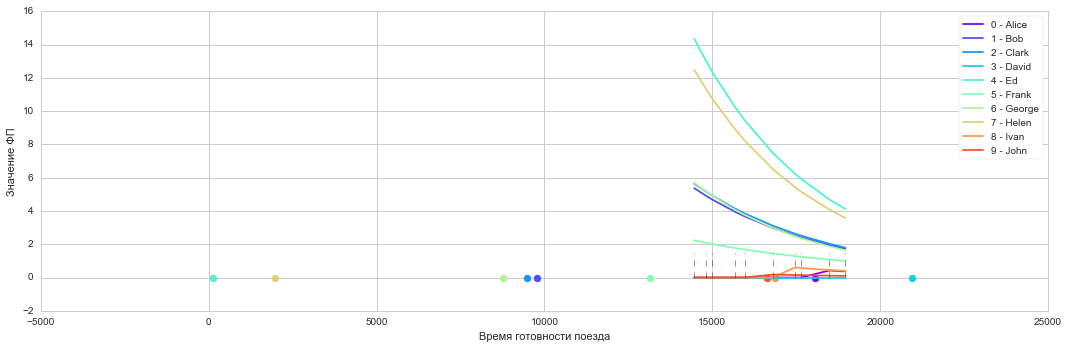

In [103]:
import seaborn as sns
import matplotlib
sns.set(style='whitegrid', context='notebook')
sns.set_color_codes('dark')
def draw(df, df_slot):
    plt.figure(figsize=(15, 5))
    cmap = matplotlib.cm.rainbow
    for i in range(len(df.index)):
        plt.plot(df_slot.ts - sd, df.ix[i][train_list], label='%d - %s' % (i, df.ix[i]['name']), color=cmap(i / float(team_num)))
        plt.scatter(df.ix[i].ts - sd, 0.0, color=cmap(i / float(team_num)), s=50)

    plt.xlabel('Время готовности поезда')
    plt.ylabel('Значение ФП')
    for t in df_slot.ts.values:
        plt.plot([t - sd] * 100, np.linspace(0, 1.5, 100), 'r--', lw=0.5)

    plt.legend(loc='best', frameon=True)
    plt.tight_layout()
    
draw(df, df_slot)

### Тезисы

1. В среднем, бригады должны подвязываться к поездам по порядку: первяа бригада на первый поезд, вторая бригада на второй поезд и т.д. 
2. Исключения могут быть для оборотных бригад.
3. П.1. должен выполняться, в первую очередь, когда количество поездов больше или равно количеству бригад. В этом случае надо, в первую очередь, стремиться вывезти более ранние поезда. В случае, когда поездов меньше, чем бригад, можно выбирать бригады из соображений оптимальности: подвязывать те бригады, которые меньше времени проведут в ожидании поезда.

### Предлагаемая реализация

1. Проблемы возникают из-за того, что времена готовности поездов и бригад могут быть сильно сдвинуты друг относительно друга. Поэтому есть идея их нормировать и привести к одному началу координат. Поэтому:
  1. У всех бригад, доступных на данном шаге планирования, преобразовываем время готовности по формуле $$t_T := \frac{t_T - \min(t_T)}{\max(t_T) - \min(t_T)}$$.
  2. Аналогично преобразуются времена готовности поездов, которые надо запланировать на данном шаге: $$t_i := \frac{t_i - \min(t_i)}{\max(t_i) - \min(t_i)}$$
    Исходные времена должны быть выражены в секундах.  
  3. После этих преобразований времена готовности поездов и бригад окажутся распределенными от 0 до 1. Разумеется, эти преобразования надо делать временно, только в рамках вычисления слагаемого ФП на данном шаге.
2. Далее для каждой пары <поезд, бригада> полезность считается по формуле: $$U_{i,T} = \exp\left(-k\cdot\Delta^2\right), \quad \Delta = t_i - t_T$$, где $t_i$ - обновленное время готовности поезда, $t_T$ - обновленное время готовности бригады. Коэффициент $k$ подбирается эмпирически, чтобы разброс значений по этому критерию был заметен. При маленьких $k$ ($k<1$) все значения будут незначительно отличаться от 1, при больших $k$ будет очень резкий переход значений от 0 к 1. Вероятно, оптимально будет брать значение $k=\max\left(\frac{\dim(t_i)}{10}, \frac{\dim(t_T)}{10}\right)$.
3. График данной функции показан на рисунке ниже. Видно, что максимум достигается при совпадении времен поезда и бригады. После проведенных нормировки и смещения большие значения ФП будет принимать в тех случаях, когда номер бригады (по порядку) примерно будет совпадать с номером поезда (по порядку). При сильно различающихся количествах бригад и поездов возможны некоторые сдвиги относительно такой симметрии, но они кажутся допустиыми. Значение ФП по этому критерию ограничено сверху единицей.

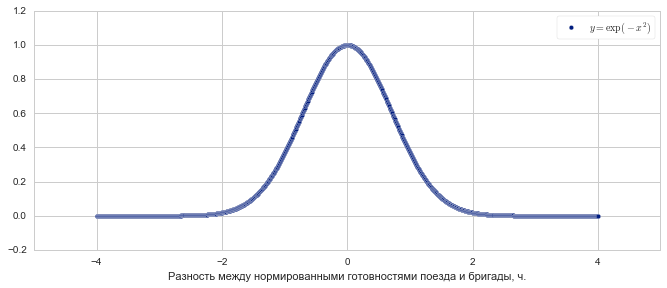

In [104]:
x = np.linspace(-4, 4, 1000)
y = np.exp(-x**2)
plt.figure(figsize=(10, 4))
plt.scatter(x, y, label = '$y=\exp(-x^2)$')
plt.xlabel('Разность между нормированными готовностями поезда и бригады, ч.')
plt.legend(frameon=True)
plt.show()

1.0


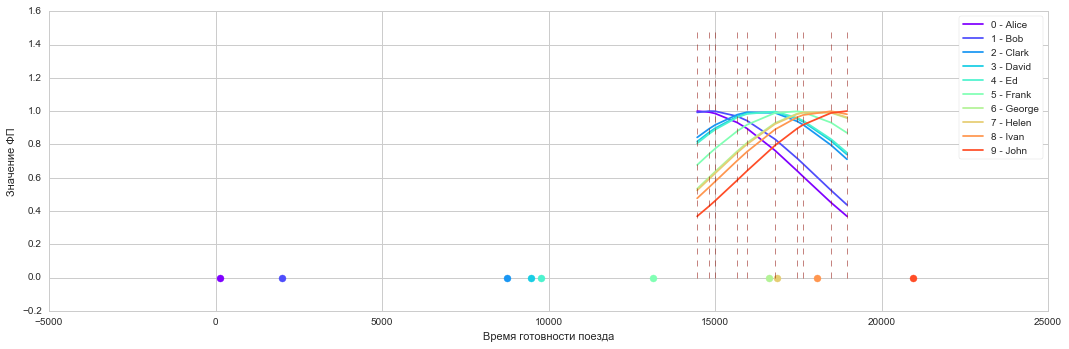

In [120]:
def get_util(x):
    u = []
    t_t = x.ts_norm
    for t_i in train_times:
        add = 0 if x.tt == 1 else 1 - (t_i - t_t) / 15000        
        #delta = (t_i - t_t) / 3600       
        delta = COEF * (t_i - t_t)
        util = np.exp(-(delta ** 2))# + 0.1 * add
        u.append(util)
    return pd.Series(u)   
    
df['ts_norm'] = (df.ts - df.ts.mean()) / (df.ts.max() - df.ts.min())
df = df.sort_values('ts').reset_index()
df['name'] = names[:team_num]
df.drop('index', axis=1, inplace=True)
df_slot['ts_norm'] = (df_slot.ts - df_slot.ts.mean()) / (df_slot.ts.max() - df_slot.ts.min())
norm_sh = df.ts_norm.min() - df_slot.ts_norm.min()
df_slot['ts_norm_shift'] = df_slot.ts_norm + norm_sh
df_slot = df_slot.reset_index().drop('index', axis=1)
COEF = max(len(df.ts_norm), len(df_slot.ts_norm)) / 10
print(COEF)

df.drop([x for x in df.columns if 'train' in x], axis=1, inplace=True)
train_list = sorted(df_slot.name.unique())
train_times = list(df_slot.ts_norm_shift.values)
df[train_list] = df.apply(lambda x: get_util(x), axis=1)
draw(df, df_slot)

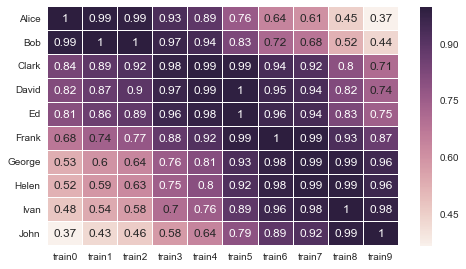

In [121]:
plt.figure(figsize=(len(df_slot.index)*0.7, len(df.index)*0.4))
sns.heatmap(df[train_list], annot=True, lw=0.01, yticklabels=df['name'].values)

In [107]:
from scipy import optimize
row, col = optimize.linear_sum_assignment(-df[train_list].as_matrix())
print(sorted(list(zip(['train %d' % t for t in col], df.ix[row].name))))
df['bt'] = -1
df.ix[row, 'bt'] = col

def get_max(row):
    l = row[train_list]
    is_max = row.index == ('train' + str(int(row.bt)))    
    return ['background-color: yellow' if v else '' for v in is_max]    

print(df_slot[['name', 'time', 'ts_norm']])
df.sort_values('ts').style.apply(get_max, axis=1)

[('train 0', 'Alice'), ('train 1', 'Bob'), ('train 2', 'Clark'), ('train 3', 'David'), ('train 4', 'Ed'), ('train 5', 'Frank'), ('train 6', 'George'), ('train 7', 'Helen'), ('train 8', 'Ivan'), ('train 9', 'John')]
     name                time   ts_norm
0  train0 2016-08-04 04:01:00 -0.458667
1  train1 2016-08-04 04:07:00 -0.378667
2  train2 2016-08-04 04:10:00 -0.338667
3  train3 2016-08-04 04:21:00 -0.192000
4  train4 2016-08-04 04:26:00 -0.125333
5  train5 2016-08-04 04:40:00  0.061333
6  train6 2016-08-04 04:51:00  0.208000
7  train7 2016-08-04 04:54:00  0.248000
8  train8 2016-08-04 05:08:00  0.434667
9  train9 2016-08-04 05:16:00  0.541333


[В начало](#toc)
## Равномерное распределение остатка поездов по часам

### Описание алгоритма

Пусть $s(i)$ - количество ниток на отправление/прибытие в часовом интервале $i$, $t(i)$ - количество запланированных поездов соответствующего типа (определение типа см. ниже) в часовом интервале $i$.

**Сокращаем почасовое количество поездов так, чтобы оно не превышало количество ниток**

1. Для каждого интервала: если $t(i) > s(i)$, то $t(i) := s(i)$, в противном случае оставляем $t(i)$ без изменения.

**Вычисляем остаток**

1. Количество поездов, которое осталось распланировать $\Delta = S - \sum_i t(i)$, где $S$ - количество поездов из АС ССП нужного типа.

**Допланируем остаток, стараясь соблюдать равномерность**

1. Считаем $\Delta_m = \left[\frac{\Delta}{24}\right]$, где $[]$ - целая часть числа.
2. Обновляем значения $t(i)$: если $t(i) + \Delta_m \leq s(i)$, то $t(i) := t(i) + \Delta_m$, иначе $t(i) := s(i)$.
3. Считаем почасовые "остатки пропускных способностей": $r(i) = s(i) - t(i)$.
4. Сортируем всю таблицу по $r(i)$ (по убыванию) и по $t(i)$ (по возрастанию). 
5. Берем первый интервал $i_0$ в отсортированной таблице, увеличиваем $t(i_0)$ на единицу. Таким образом мы добавим один поезд в тот интервал, где осталось больше всего незанятых ниток и где уже запланировано меньше поездов.
6. Считаем $\Delta = S - \sum_i t(i)$. Если $\Delta = 0$, то алгоритм завершен. Если $\Delta > 0$, то повторяем с шага 3.

### FAQ

**Если $\Delta < 0$?**

Значит, планировщик даже перевыполнил задание АС ССП. Пока предлагаю в этом случае ничего не делать.

**Что такое "нужный тип" при определении параметров?**

В АС ССП отдельно задаются количества поездов на отправление, на отправление своего формирования, на прибытие, на прибытие в разборку. "Нужные типы" поездов - это:
* поезда на отправление НЕ своего формирования;
* поезда на отправление своего формирования;
* поезда на прибытие НЕ в разборку;
* поезда на прибытие в разборку.

При вычислении $t(i)$ надо брать только поезда соответствующего типа. Количество ниток брать, соответственно, либо по отправлению, либо по прибытию. Норму ССП брать тоже соответствующего типа, при этом поезда НЕ с.ф. и поезда НЕ в разборку надо вычислять - но это просто разность между количеством поездов всего и количеством поездов с.ф. (или в рзб.).

**Будет ли согласовано в этом случае количество поездов на прибытие и на отправление?**

Нет, никакой связки не делается. Чтобы ее сделать, надо опускаться на уровень отслеживания конкретных поездов, причем часовой детализации недостаточно: для поездов надо будет вести точное время прибытия/отправления, точное время хода по ниткам. Это все делается на уровне текущего планирования.

**Учитывается ли как-то занятость путей?**

Нет, причины примерно такие же, как и в предыдущем пункте. Но если мы делаем достаточно хорошее равномерное распределение, то с большой вероятностью можно ожидать, что случаев превышения количества путей будет крайне мало (или не будет вообще).

### Пример

Рассматривается отправление поездов со станции Иркутск-Сортировочный в четном направлении. Всего планировщик смог запланировать 56 поездов, задание ССП было установлено в 70 поездов.

Проверка проводилась на расчете планировщика от 07:30 08.08.2016.

In [21]:
'''
    df_init - исходный датафрейм
    slot_col - название колонки с почасовым количеством ниток
    init_trains_col - название колонки с исходным количество поездов
    trains_num - общее количество поездов, которое надо запланировать
'''

def allocate(df_init, slot_col, init_trains_col, trains_num):
    df = df_init.sort_index().copy()
    if init_trains_col not in df.columns:
        df[init_trains_col] = 0
    mean = int((trains_num - df[init_trains_col].sum()) / 24)
    df['trains'] = df.apply(lambda row: mean + row[init_trains_col] if mean + row[init_trains_col] < row[slot_col] \
                          else row[slot_col], axis=1)
    df['res'] = df.slot - df.trains
    d = trains_num - df.trains.sum()
    cnt = 0
    while (d != 0) & (cnt < 100):
        if d > 0:
            df = df.sort_values(['res', 'trains'], ascending=[False, True])
            l = list(df.trains)       
            df['trains'] = [l[0] + 1] + l[1:]
        else:
            df = df.sort_values(['res', 'trains'], ascending=[True, False])
            l = list(df.trains)
            df['trains'] = [l[0] - 1] + l[1:]
        df['res'] = df[slot_col] - df.trains
        d = trains_num - df.trains.sum()    
        cnt += 1
    return(df.sort_index()['trains'])

In [22]:
import datetime as dt

%run common.py
slot = pd.read_csv(FOLDER + 'slot.csv', dtype={'st_from':str, 'st_to':str})
add_info(slot)
st1 = 'ИРКУТСК-СОРТИРОВОЧНЫЙ'
st2 = 'ГОНЧАРОВО'
slot.drop(['st_from', 'st_to', 'link', 'time_start_norm', 'time_end_norm'], axis=1, inplace=True)

Planning start time: Aug 09, 07:30 (1470717049)


In [28]:
slot['dt_start'] = slot.time_start.apply(dt.datetime.fromtimestamp)
slot['dt_end'] = slot.time_end.apply(dt.datetime.fromtimestamp)
a = slot[(slot.st_from_name == st1) & (slot.st_to_name == st2) 
     & (slot.time_start >= current_time) & (slot.time_end < current_time + 24 * 3600)]
dep = a.set_index('dt_start').slot.resample('1H', 'count').to_frame()
train_plan['dt_start'] = train_plan.time_start.apply(dt.datetime.fromtimestamp)
train_plan['train_type'] = train_plan.train.apply(lambda x: int(x[0]))
b = train_plan[(train_plan.st_from_name == st1) & (train_plan.st_to_name == st2)
              & (train_plan.time_start >= current_time) & (train_plan.time_end < current_time + 24 * 3600)
              & (train_plan.train_type != 8)]
dep['trains'] = b.set_index('dt_start').train.resample('1H', 'count').to_frame()
dep['init_trains'] = dep.apply(lambda row: row.trains if row.trains <= row.slot else row.slot, axis=1)
dep['tfill'] = allocate(dep, 'slot', 'init_trains', 70)
dep['zero_fill'] = allocate(dep, 'slot', 'zero_init', 50)
dep['check_before'] = dep.trains <= dep.slot
dep['check_after'] = dep.tfill <= dep.slot
print(dep.to_string())

                     slot  trains  init_trains  tfill  zero_fill check_before check_after
dt_start                                                                                 
2016-08-09 07:00:00     2       1            1      1          2         True        True
2016-08-09 08:00:00     6       5            5      5          3         True        True
2016-08-09 09:00:00     2       2            2      2          2         True        True
2016-08-09 10:00:00     5       7            5      5          2        False        True
2016-08-09 11:00:00     6       8            6      6          3        False        True
2016-08-09 12:00:00     3       3            3      3          2         True        True
2016-08-09 13:00:00     3       0            0      2          2         True        True
2016-08-09 14:00:00     4       0            0      3          2         True        True
2016-08-09 15:00:00     3       0            0      2          2         True        True
2016-08-09

В столбце `slot` приведено почасовое распределение ниток, в столбце `trains` - исходное почасовое распределение поездов после работы планировщика, в столбце `init_trains` - "причесанное" количество поездов после его сокращения до количества ниток в часе, в столбце `tfill` - итоговое количество поездов после допланирования.

В столбце `check_before` указан результат проверки на превышение кол-ва ниток для изначального планирования, в столбце `check_after` - аналогичный результат для проверки после допланирования. Видно, что изначально было несколько случаев нарушений, а после допланирования их нет.

Итоговые суммы по столбцам приведены ниже. Стоит заметить, что всего в планировщик было передано 83 нитки - а значит, он не смог бы запланировать больше 83 поездов.

Также приведены стандартные отклонения (корень из дисперсии) для распределения количества ниток и поездов. При достаточно хорошем равномерном распределении ожидается, что отклонение для поездов будет хотя бы меньше отклонения для распределения ниток. Также ожидается, что отклонение будет значительно меньше, чем std для предельного случая, когда все поезда сосредоточены в начале суток. Ожидания подтверждаются.

In [29]:
print('Ниток: %d\nПоездов изначально: %d\nПоездов после допланирования: %d' 
      % (dep.slot.sum(), dep.trains.sum(), dep.tfill.sum()))
test = [2, 6, 2, 5, 6, 3, 3, 4, 3, 1, 4, 3, 3, 5, 3, 5, 5, 6, 1, 0, 0, 0, 0, 0]
print('\nСтандартные отклонения (тестовое, по ниткам, по поездам до и после допланирования): %.3f, %.3f, %.3f, %.3f %.3f' %
      (np.std(test), np.std(dep.slot), np.std(dep.trains), np.std(dep.tfill), np.std(dep.zero_fill)))

Ниток: 83
Поездов изначально: 58
Поездов после допланирования: 70

Стандартные отклонения (тестовое, по ниткам, по поездам до и после допланирования): 2.040, 1.471, 2.263, 1.441 0.400


[В начало](#toc)
## Исправления в обработке входных данных

1. Не отсекать бригаду, если время операции по бригаде не совпадает с временем операции у локомотива. Если у них при этом совпадают местоположения, то в качестве верного брать максимальное время из двух. Аналогично - для связки поезд-локомотив.
  1. Вместе с этим проверить ошибку: если бригада отсеяна на входе, то поезд протягивается до ближайшей станции смены бригад. Но ищется не ближайшая станция смены, а какая-то другая. Как проверить: модельный сценарий, бригада 8800019 едет на участке Юрты - Тайшет. Локомотив меняется в Тайшете, бригада (точнее, "отсутствие бригады" следует до Вихоревки). Работает, если у бригады поставить время, отличающееся от локомотивного.

---
## Планы работ на ближайшее будущее

#### Задачи на Костю:

1. ~~**Фиксация времени явки от предыдущего расчета (29.07).**~~
2. ~~**Сдвиг явки УТХ-бригад (02.08).**~~
3. **Пост-планирование (создание фейковых бригад для фейковых локомотивов) (03.08 - возможно, заработает сразу?).**
4. **Подвязывать поезда точно на нитки.**
5. Возвратные скачки по времени. Достаточно много у локомотивов.
6. Бригады в state = 2:
  1. Неверно планируются (практически не подвязываются под поезда):
    1. Выявить случаи очень ранней явки, проверить по операциям, что случилось с бригадами.
    2. Написать постановку на учет (подвязывать их как можно скорее, явку не переносить).
  2. Создаются фейковые бригады только со state=2.
7. При расчете времени отдыха бригады не учитывается, что явка могла быть до начала планирования.
  1. Проверить. Возможно, уже исправлено.
8. Явка бригады создается до начала планирования.
9. Бесцельная пересадка бригады с поезда на поезд.
  1. Выявить (по возможности) все такие случаи. 
  
#### Задачи на Борю:

1. Фикс багов с ТО и ограничение времени на пересылку локомотивов резервом.
2. Пост-планирование и создание фейковых локомотивов.
3. Подвязка нескольких локомотивов под один поезд.
4. Объединение резервных локомотивов в сплотки.